In [12]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report




In [2]:
# Load the dataset
data_path = 'Combined_Flights_small.csv'
data = pd.read_csv(data_path)

# Display general information about the dataset
print("Column Names:")
print(data.columns.tolist())
print("\nData Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())
print("\nNumber of Unique Values:")
print(data.nunique())
print("\nTarget Variable Distribution:")
print(data['Disruption'].value_counts())

Column Names:
['Unnamed: 0', 'FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'CRSDepTime', 'CRSElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepTimeBlk', 'CRSArrTime', 'ArrDel15', 'ArrTimeBlk', 'DistanceGroup', 'Disruption']

Data Types:
Unnamed: 0                                   int64
FlightDate                                  object
Airline                       

In [3]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'Cancelled', 'Diverted', 'ArrDel15']
data.drop(columns=columns_to_drop, inplace=True)

# Identify features and target variable
X = data.drop('Disruption', axis=1)
y = data['Disruption']

# Create a new feature 'Weekend' indicating whether the flight is on a weekend
data['FlightDate'] = pd.to_datetime(data['FlightDate'])
data['Weekend'] = (data['FlightDate'].dt.dayofweek >= 5).astype(int)

# Create a new feature 'MorningFlight' indicating whether the flight departs in the morning
data['CRSDepTime'] = pd.to_datetime(data['CRSDepTime'], format='%H%M', errors='coerce')
data['MorningFlight'] = ((data['CRSDepTime'].dt.hour >= 6) & (data['CRSDepTime'].dt.hour < 12)).astype(int)

# Add the newly created features to DataFrame 'X'
X['Weekend'] = data['Weekend']
X['MorningFlight'] = data['MorningFlight']

# Separate categorical and numeric features
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Handling missing values in categorical features
X[categorical_features] = X[categorical_features].fillna('Unknown')

# Display the first few rows of the cleaned dataset
print("Cleaned Dataset:")
print(data.head())


Cleaned Dataset:
  FlightDate                      Airline Origin Dest          CRSDepTime  \
0 2018-09-07        SkyWest Airlines Inc.    SLC  LAX 1900-01-01 19:53:00   
1 2018-06-27  Air Wisconsin Airlines Corp    ORD  ILM 1900-01-01 13:55:00   
2 2018-03-14       Southwest Airlines Co.    MCO  SJU 1900-01-01 17:05:00   
3 2018-02-18              JetBlue Airways    JFK  LAX 1900-01-01 10:46:00   
4 2018-10-26            Endeavor Air Inc.    ROC  JFK 1900-01-01 18:50:00   

   CRSElapsedTime  Distance  Year  Quarter  Month  ...  DestStateFips  \
0             119       590  2018        3      9  ...              6   
1             136       760  2018        2      6  ...             37   
2             160      1189  2018        1      3  ...             72   
3             384      2475  2018        1      2  ...              6   
4              98       264  2018        4     10  ...             36   

    DestStateName DestWac DepTimeBlk  CRSArrTime ArrTimeBlk  DistanceGroup  \
0  

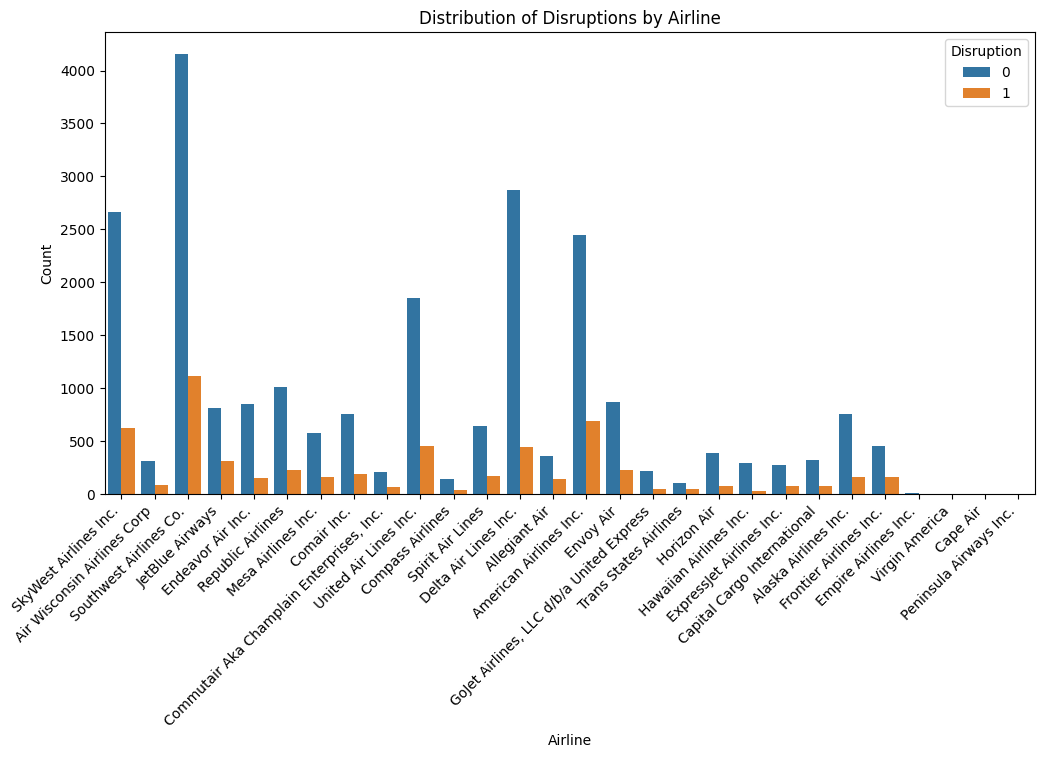

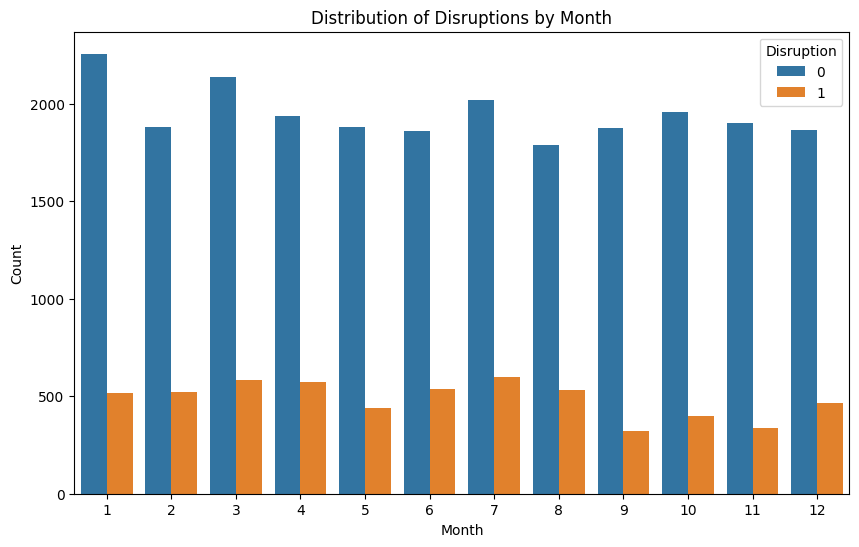

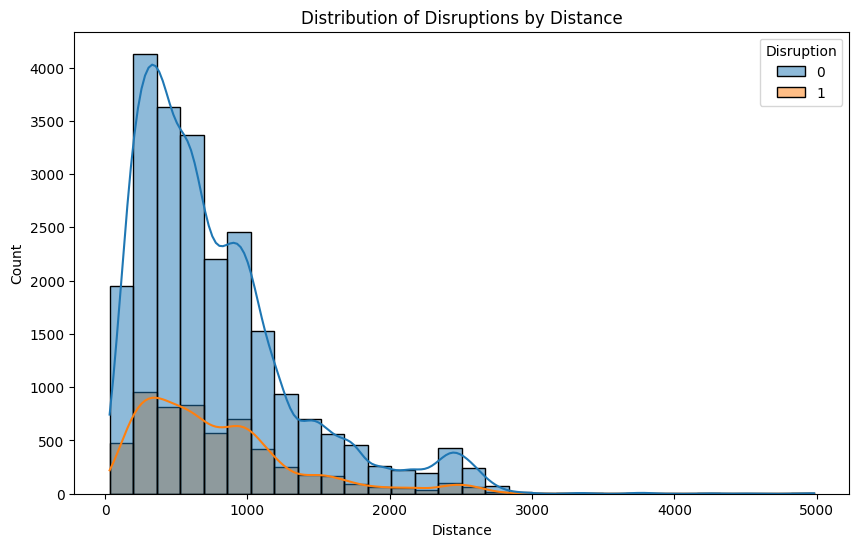

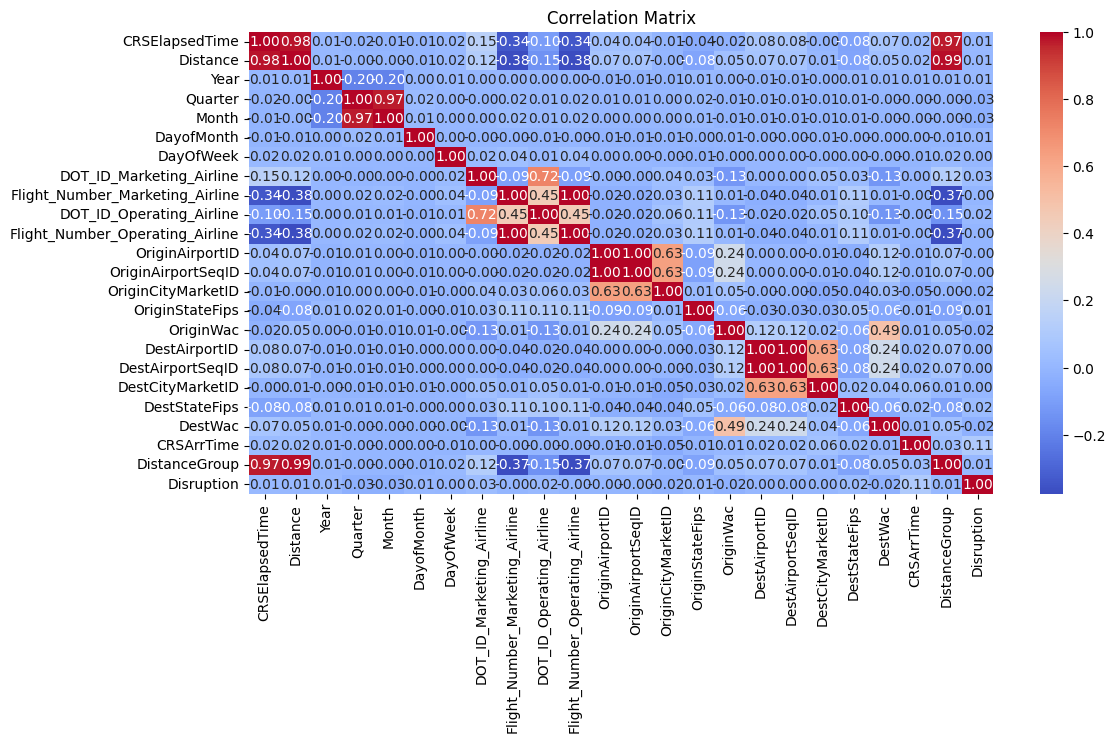

In [4]:
# Visualize the distribution of 'Airline' with respect to 'Disruption'
plt.figure(figsize=(12, 6))
sns.countplot(x='Airline', hue='Disruption', data=data)
plt.title('Distribution of Disruptions by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Visualize the distribution of disruptions over months
plt.figure(figsize=(10, 6))
sns.countplot(x='Month', hue='Disruption', data=data)
plt.title('Distribution of Disruptions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of disruptions over distance
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Distance', hue='Disruption', bins=30, kde=True)
plt.title('Distribution of Disruptions by Distance')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()

# Exclude non-numeric columns before visualizing the correlation matrix
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Visualize the correlation matrix for numerical attributes
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



In [5]:
# Create a new feature 'Weekend' indicating whether the flight is on a weekend
data['FlightDate'] = pd.to_datetime(data['FlightDate'])
data['Weekend'] = (data['FlightDate'].dt.dayofweek >= 5).astype(int)

# Create a new feature 'MorningFlight' indicating whether the flight departs in the morning
data['CRSDepTime'] = pd.to_datetime(data['CRSDepTime'], format='%H%M', errors='coerce')
data['MorningFlight'] = ((data['CRSDepTime'].dt.hour >= 6) & (data['CRSDepTime'].dt.hour < 12)).astype(int)

# Select only numeric columns for correlation calculation
numeric_columns = data.select_dtypes(include=['number']).columns

# Calculate the correlation between all numeric features and the target variable 'Disruption'
feature_target_corr = data[numeric_columns].corr()['Disruption'].abs().sort_values(ascending=False)

# Select the top N features based on correlation (excluding the target variable)
top_features = feature_target_corr[1:11]

# Display the top features
print("Top Features based on Correlation with Target Variable:")
print(top_features)



Top Features based on Correlation with Target Variable:
CRSArrTime                  0.105636
MorningFlight               0.102023
DOT_ID_Marketing_Airline    0.030108
Month                       0.029130
Quarter                     0.028477
DestWac                     0.023478
DestStateFips               0.023023
OriginWac                   0.021671
OriginCityMarketID          0.016114
DOT_ID_Operating_Airline    0.015504
Name: Disruption, dtype: float64


In [6]:
# Subset the dataset with the top features
selected_features = top_features.index.tolist()
X_selected = X[selected_features]

# Splitting the dataset into features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Display the shapes of the train and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (23352, 10) (23352,)
Testing set shape: (5839, 10) (5839,)


In [7]:
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define the pipeline for each model
logistic_regression_pipeline = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('classifier', LogisticRegression())
])

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('classifier', RandomForestClassifier())
])

xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('classifier', XGBClassifier())
])


In [8]:
# Train the models
logistic_regression_pipeline.fit(X_train, y_train)
random_forest_pipeline.fit(X_train, y_train)
xgboost_pipeline.fit(X_train, y_train)

# Make predictions on the testing data
logistic_regression_pred = logistic_regression_pipeline.predict(X_test)
random_forest_pred = random_forest_pipeline.predict(X_test)
xgboost_pred = xgboost_pipeline.predict(X_test)

# Evaluate performance using accuracy
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_pred)
random_forest_accuracy = accuracy_score(y_test, random_forest_pred)
xgboost_accuracy = accuracy_score(y_test, xgboost_pred)

# Compute confusion matrix and classification report for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, logistic_regression_pred)
class_report_lr = classification_report(y_test, logistic_regression_pred)
print("Confusion Matrix (Logistic Regression):\n", conf_matrix_lr)
print("Classification Report (Logistic Regression):\n", class_report_lr)

# Compute confusion matrix and classification report for Random Forest
conf_matrix_rf = confusion_matrix(y_test, random_forest_pred)
class_report_rf = classification_report(y_test, random_forest_pred)
print("Confusion Matrix (Random Forest):\n", conf_matrix_rf)
print("Classification Report (Random Forest):\n", class_report_rf)

# Compute confusion matrix and classification report for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, xgboost_pred)
class_report_xgb = classification_report(y_test, xgboost_pred)
print("Confusion Matrix (XGBoost):\n", conf_matrix_xgb)
print("Classification Report (XGBoost):\n", class_report_xgb)

# Print the accuracy of each model
print("Accuracy of Logistic Regression:", logistic_regression_accuracy)
print("Accuracy of Random Forest:", random_forest_accuracy)
print("Accuracy of XGBoost:", xgboost_accuracy)

Confusion Matrix (Logistic Regression):
 [[4645    0]
 [1194    0]]
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      4645
           1       0.00      0.00      0.00      1194

    accuracy                           0.80      5839
   macro avg       0.40      0.50      0.44      5839
weighted avg       0.63      0.80      0.70      5839

Confusion Matrix (Random Forest):
 [[4467  178]
 [1097   97]]
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.80      0.96      0.88      4645
           1       0.35      0.08      0.13      1194

    accuracy                           0.78      5839
   macro avg       0.58      0.52      0.50      5839
weighted avg       0.71      0.78      0.72      5839

Confusion Matrix (XGBoost):
 [[4509  136]
 [1126   68]]
Classification Report (XGBoost):
               precision    recall  f1-sc

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [9]:
# Define hyperparameters grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define hyperparameters grid for XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Perform GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=rf_param_grid,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Perform GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(estimator=XGBClassifier(random_state=42),
                               param_grid=xgb_param_grid,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Print best hyperparameters for Random Forest
print("Best hyperparameters for Random Forest:")
print(rf_grid_search.best_params_)

# Print best hyperparameters for XGBoost
print("\nBest hyperparameters for XGBoost:")
print(xgb_grid_search.best_params_)

Best hyperparameters for Random Forest:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Best hyperparameters for XGBoost:
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1}


In [10]:
# Initialize Random Forest classifier with best hyperparameters
best_rf_model = RandomForestClassifier(**rf_grid_search.best_params_, random_state=42)

# Train Random Forest model with best hyperparameters
best_rf_model.fit(X_train, y_train)

# Initialize XGBoost classifier with best hyperparameters
best_xgb_model = XGBClassifier(**xgb_grid_search.best_params_, random_state=42)

# Train XGBoost model with best hyperparameters
best_xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [13]:
# Predictions on test data for Random Forest
rf_test_predictions = best_rf_model.predict(X_test)

# Predictions on test data for XGBoost
xgb_test_predictions = best_xgb_model.predict(X_test)

# Evaluation metrics for Random Forest
rf_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_precision = precision_score(y_test, rf_test_predictions)
rf_recall = recall_score(y_test, rf_test_predictions)
rf_f1 = f1_score(y_test, rf_test_predictions)

print("Random Forest Performance on Test Data:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)

# Evaluation metrics for XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_test_predictions)
xgb_precision = precision_score(y_test, xgb_test_predictions)
xgb_recall = recall_score(y_test, xgb_test_predictions)
xgb_f1 = f1_score(y_test, xgb_test_predictions)

print("\nXGBoost Performance on Test Data:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1-score:", xgb_f1)

Random Forest Performance on Test Data:
Accuracy: 0.7958554547011475
Precision: 0.75
Recall: 0.002512562814070352
F1-score: 0.005008347245409015

XGBoost Performance on Test Data:
Accuracy: 0.7955129302962836
Precision: 0.0
Recall: 0.0
F1-score: 0.0


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
